<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [5]:
student_number = '98170657'
first_name = 'Helia'
last_name = 'AkhtarKavian'

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
from cvxopt import matrix, solvers
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable.

In [114]:
data = pd.read_csv("./Data/satimage.csv")

features = data.drop(columns=["label"])
label = data["label"]

Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [115]:
train_features, temp_features, train_labels, temp_labels = train_test_split(features, label, test_size=0.4, random_state=42)

validation_features, test_features, validation_labels, test_labels = train_test_split(temp_features, temp_labels, test_size=0.625, random_state=42)

feature_scaler = StandardScaler()
normalized_train_features = feature_scaler.fit_transform(train_features)
normalized_validation_features = feature_scaler.transform(validation_features)
normalized_test_features = feature_scaler.transform(test_features)

We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

In [116]:
def filter_labels(labels):
    filtered = []
    for label in labels:
        filtered.append(label in (4, 6))
    return filtered

def map_labels(labels):
    return labels.apply(lambda x: 1 if x == 4 else -1)

train_filter = filter_labels(train_labels)
validation_filter = filter_labels(validation_labels)
test_filter = filter_labels(test_labels)

filtered_train_features = normalized_train_features[train_filter]
filtered_train_labels = map_labels(train_labels[train_filter])

filtered_validation_features = normalized_validation_features[validation_filter]
filtered_validation_labels = map_labels(validation_labels[validation_filter])

filtered_test_features = normalized_test_features[test_filter]
filtered_test_labels = map_labels(test_labels[test_filter])

model = SVC(kernel='linear')
model.fit(filtered_train_features, filtered_train_labels)

SVC(kernel='linear')

# Model (50 points)

Here is soft margin svm convex optimization formulation.
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$
write dual of the soft margin svm optimization problem below:

$$
\begin{aligned}
\text { Maximize } & \quad \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j \mathbf{x}_i^T \mathbf{x}_j \\
\text { Subject to } & \quad \sum_{i=1}^N \alpha_i y_i = 0 \\
& \quad 0 \leq \alpha_i \leq C, \quad i = 1, 2, \ldots, N
\end{aligned}
$$

This formulation allows solving the SVM problem by only working with the dot products of the input vectors, which is particularly beneficial when applying kernel methods for non-linear classification.

Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


In [117]:
def soft_margin_svm(features, labels, penalty_weight):
    """
    Args:
        features: Data matrix containing training samples
        labels: Array containing labels for training samples
        penalty_weight: Regularization parameter for margin violation
    Returns:
        sv_data: Support vectors identified by the model
        sv_labels: Corresponding labels of the support vectors
        sv_alphas: Lagrange multipliers associated with the support vectors
    """

    n_samples, n_features = features.shape
    gram = np.dot(features, features.T) * np.outer(labels, labels)
    quadratic_term = matrix(gram)
    linear_term = matrix(-np.ones((n_samples, 1)))
    combined_bounds = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    inequality_constraints = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * penalty_weight)))
    label_constraint = matrix(labels, (1, n_samples), 'd')
    intercept_term = matrix(0.0)
    solution = solvers.qp(quadratic_term, linear_term, combined_bounds, inequality_constraints, label_constraint, intercept_term)
    lagrange_multipliers = np.array(solution['x']).flatten()
    sv_data = features
    sv_labels = labels
    sv_alphas = lagrange_multipliers
    return sv_data, sv_labels, sv_alphas

In [118]:
sv, sv_labels, sv_alphas = soft_margin_svm(filtered_train_features, filtered_train_labels, 1)

     pcost       dcost       gap    pres   dres
 0: -6.1265e+02 -3.3971e+03  2e+04  3e+00  2e-13
 1: -4.1824e+02 -2.2816e+03  3e+03  3e-01  1e-13
 2: -3.9732e+02 -7.6474e+02  4e+02  3e-02  9e-14
 3: -4.4111e+02 -5.8227e+02  2e+02  9e-03  9e-14
 4: -4.6125e+02 -5.3708e+02  8e+01  4e-03  9e-14
 5: -4.7293e+02 -5.1305e+02  4e+01  2e-03  9e-14
 6: -4.7763e+02 -5.0407e+02  3e+01  1e-03  9e-14
 7: -4.8272e+02 -4.9477e+02  1e+01  4e-04  9e-14
 8: -4.8534e+02 -4.9054e+02  5e+00  2e-04  1e-13
 9: -4.8671e+02 -4.8840e+02  2e+00  4e-05  1e-13
10: -4.8718e+02 -4.8773e+02  6e-01  7e-06  1e-13
11: -4.8738e+02 -4.8747e+02  9e-02  4e-07  1e-13
12: -4.8742e+02 -4.8743e+02  7e-03  3e-08  1e-13
13: -4.8742e+02 -4.8742e+02  2e-04  6e-10  1e-13
Optimal solution found.


In [119]:
def predict(test_data, sv_data, sv_labels, sv_alphas):
    """
    Args:
        test_data: Matrix containing the data points to classify
        sv_data: Matrix containing support vectors identified by the model
        sv_labels: Array containing labels corresponding to the support vectors
        sv_alphas: Lagrange multipliers associated with the support vectors

    Returns:
        predicted_labels: Array of predicted labels for the input test data
    """

    linear_combination = np.dot(test_data, sv_data.T)
    decision_output = np.dot(linear_combination, sv_alphas * sv_labels)
    predicted_labels = np.sign(decision_output)
    return predicted_labels

In [120]:
predicted_labels = predict(np.array(filtered_test_features), sv, sv_labels, sv_alphas)

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [121]:
def evaluate(true_labels, predicted_labels):
    """
    Args:
        true_labels: Ground truth labels for the dataset
        predicted_labels: Labels predicted by the model
    
    Returns:
        model_accuracy: Overall accuracy of the model
        balanced_model_accuracy: Balanced accuracy of the model
        confusion_mat: Confusion matrix reflecting model performance
    """

    model_accuracy = accuracy_score(true_labels, predicted_labels)
    balanced_model_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    print("Model Accuracy:", model_accuracy)
    print("Balanced Accuracy:", balanced_model_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    return model_accuracy, balanced_model_accuracy, confusion_mat

overall_accuracy, balanced_accuracy, confusion_mat = evaluate(filtered_test_labels, predicted_labels)

Model Accuracy: 0.8252788104089219
Balanced Accuracy: 0.7639855133496167
Confusion Matrix:
 [[348  35]
 [ 59  96]]


<Axes: >

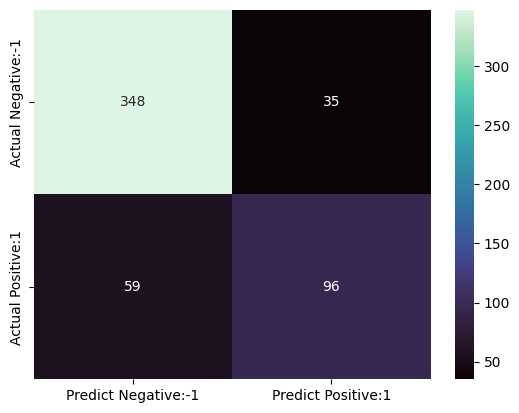

In [122]:
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [123]:
def rbf_kernel(vector1, vector2, kernel_gamma=1):
    """
    Args:
        vector1: First input vector
        vector2: Second input vector
        kernel_gamma: RBF kernel parameter (default value is 1)

    Returns:
        rbf_value: Computed RBF value between the two input vectors
    """
    squared_diff = np.sum((vector1 - vector2) ** 2)
    return np.exp(-kernel_gamma * squared_diff)

def soft_margin_svm(features, labels, penalty_weight, kernel_gamma=1):
    """
    Args:
        features: Input training feature matrix
        labels: Labels for training data
        penalty_weight: Regularization parameter for margin violation
        kernel_gamma: RBF kernel parameter with a default value of 1

    Returns:
        sv_data: Support vectors found by the model
        sv_labels: Corresponding labels of the support vectors
        sv_alphas: Coefficients for the support vectors
    """

    num_samples, num_features = features.shape
    kernel_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            kernel_matrix[i, j] = rbf_kernel(features[i], features[j], kernel_gamma)

    quadratic_term = matrix(np.outer(labels, labels) * kernel_matrix)
    linear_term = matrix(-np.ones((num_samples, 1)))
    combined_bounds = matrix(np.vstack((-np.eye(num_samples), np.eye(num_samples))))
    inequality_constraints = matrix(np.hstack((np.zeros(num_samples), np.ones(num_samples) * penalty_weight)))
    label_constraint = matrix(labels, (1, num_samples), 'd')
    intercept_term = matrix(0.0)
    solution = solvers.qp(quadratic_term, linear_term, combined_bounds, inequality_constraints, label_constraint, intercept_term)
    lagrange_multipliers = np.array(solution['x']).flatten()
    sv_data = features
    sv_labels = labels
    sv_alphas = lagrange_multipliers
    return sv_data, sv_labels, sv_alphas

In [132]:
gamma_values = [0.01, 0.1, 1, 10, 100]
optimal_gamma = None
optimal_sv = None
optimal_sv_labels = None
optimal_sv_alphas = None
highest_balanced_acc = None
idx = 0
while idx < len(gamma_values):
    gamma = gamma_values[idx]
    print(f'current gamma: {gamma}')
    sv, sv_labels, sv_alphas = soft_margin_svm(filtered_validation_features, filtered_validation_labels, penalty_weight=1.0, kernel_gamma=gamma)
    test_predictions = predict(np.array(filtered_test_features), sv, sv_labels, sv_alphas)
    accuracy, balanced_accuracy, confusion_matrix_results = evaluate(filtered_test_labels, test_predictions)
    if highest_balanced_acc is None or balanced_accuracy > highest_balanced_acc:
        highest_balanced_acc = balanced_accuracy
        optimal_sv = sv
        optimal_sv_labels = sv_labels
        optimal_sv_alphas = sv_alphas
        optimal_gamma = gamma
    idx += 1
print('---------------------------')
print(f'Optimal gamma value found: {optimal_gamma}')

current gamma: 0.01
     pcost       dcost       gap    pres   dres
 0: -1.5833e+02 -7.2035e+02  3e+03  2e+00  4e-15
 1: -1.1278e+02 -4.4552e+02  4e+02  1e-01  3e-15
 2: -1.2405e+02 -1.7900e+02  6e+01  2e-02  3e-15
 3: -1.3712e+02 -1.5472e+02  2e+01  4e-03  3e-15
 4: -1.4177e+02 -1.4733e+02  6e+00  9e-04  3e-15
 5: -1.4328e+02 -1.4513e+02  2e+00  2e-04  3e-15
 6: -1.4385e+02 -1.4435e+02  5e-01  5e-05  3e-15
 7: -1.4405e+02 -1.4408e+02  2e-02  1e-06  4e-15
 8: -1.4406e+02 -1.4406e+02  6e-04  3e-08  4e-15
 9: -1.4406e+02 -1.4406e+02  2e-05  8e-10  3e-15
Optimal solution found.
Model Accuracy: 0.8066914498141264
Balanced Accuracy: 0.7125242146045649
Confusion Matrix:
 [[358  25]
 [ 79  76]]
current gamma: 0.1
     pcost       dcost       gap    pres   dres
 0: -9.4677e+01 -6.5677e+02  3e+03  2e+00  1e-15
 1: -7.4100e+01 -3.7439e+02  3e+02  7e-02  1e-15
 2: -8.1270e+01 -1.3766e+02  6e+01  1e-02  1e-15
 3: -9.1058e+01 -1.0314e+02  1e+01  2e-03  1e-15
 4: -9.4084e+01 -9.7232e+01  3e+00  3e-0

In [133]:
test_predictions = predict(np.array(filtered_test_features), optimal_sv, optimal_sv_labels, optimal_sv_alphas)
_, _, confusion_mat = evaluate(filtered_test_labels, test_predictions)

Model Accuracy: 0.8104089219330854
Balanced Accuracy: 0.7439400320053904
Confusion Matrix:
 [[345  38]
 [ 64  91]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

In [144]:
model = SVC()
cross_validator = GridSearchCV(model, {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']}, cv=5)
cross_validator.fit(filtered_train_features, filtered_train_labels)
print("optimal_params:", cross_validator.best_params_)
print("optima_score:", cross_validator.best_score_)

optimal_params: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
optima_score: 0.8996732127851608


Implement Multiclass SVM from scratch without using ready functions (optional).

In [146]:
def train_one_vs_one_svm(features, labels, penalty_weight, kernel_gamma):
    """
     Args:
        features: Input training feature matrix
        labels: Labels for training data
        penalty_weight: Regularization parameter for margin violation
        kernel_gamma: RBF kernel parameter

    Returns:
        ovo_classifiers: A list containing tuples of model parameters for each class pair.
    """
    unique_classes = np.unique(labels)
    ovo_classifiers = []
    for i in range(len(unique_classes)):
        for j in range(i + 1, len(unique_classes)):
            class_i = unique_classes[i]
            class_j = unique_classes[j]
            relevant_indices = (labels == class_i) | (labels == class_j)
            X_pair = X_data[relevant_indices]
            y_pair = labels[relevant_indices]
            binary_labels = np.where(y_pair == class_i, 1, -1)
            sv, sv_labels, sv_alphas = soft_margin_svm(X_pair, binary_labels, penalty_weight, kernel_gamma)
            ovo_classifiers.append((sv, sv_labels, sv_alphas, class_i, class_j))
    return ovo_classifiers

def predict_one_vs_one(test_data, classifiers):
    """
    Args:
        test_data: Test dataset.
        classifiers: List of classifiers trained on each class pair.

    Returns:
        final_predictions: Predicted labels for each test data sample.
    """
    decision_scores = np.zeros((len(test_data), len(np.unique([cls[-2] for cls in classifiers]))))
    for sv, sv_labels, sv_alphas, class_i, class_j in classifiers:
        predictions = predict(test_data, [(sv, sv_labels, sv_alphas, class_i)])
        for index, predict in enumerate(predictions):
            class_index = class_i if predict == 1 else class_j
            decision_scores[index, class_index] += 1
    final_predictions = np.argmax(decision_scores, axis=1)
    return final_predictions

# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

In [152]:
model = SVC(kernel='linear')
model.fit(filtered_train_features, filtered_train_labels)
prediction = model.predict(filtered_test_features)
acc = accuracy_score(filtered_test_labels, prediction)
bal_acc = balanced_accuracy_score(filtered_test_labels, prediction)
cm = confusion_matrix(filtered_test_labels, prediction)

print(f"Accuracy: {acc}")
print(f"Balanced Accuracy: {bal_acc}")
print("Confusion Matrix :\n", cm)

Accuracy: 0.8513011152416357
Balanced Accuracy: 0.820668744209551
Confusion Matrix :
 [[342  41]
 [ 39 116]]


### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part.

In [153]:
model = SVC(kernel='rbf', gamma='scale')
model.fit(filtered_train_features, filtered_train_labels)
prediction = model.predict(filtered_test_features)
acc = accuracy_score(filtered_test_labels, prediction)
bal_acc = balanced_accuracy_score(filtered_test_labels, prediction)
cm = confusion_matrix(filtered_test_labels, prediction)

print(f"Accuracy: {acc}")
print(f"Balanced Accuracy: {bal_acc}")
print("Confusion Matrix :\n", cm)

Accuracy: 0.8754646840148699
Balanced Accuracy: 0.8683651983491956
Confusion Matrix :
 [[339  44]
 [ 23 132]]


### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

In [154]:
model = SVC(kernel='poly', degree=3)
model.fit(filtered_train_features, filtered_train_labels)
prediction = model.predict(filtered_test_features)
acc = accuracy_score(filtered_test_labels, prediction)
bal_acc = balanced_accuracy_score(filtered_test_labels, prediction)
cm = confusion_matrix(filtered_test_labels, prediction)

print(f"Accuracy: {acc}")
print(f"Balanced Accuracy: {bal_acc}")
print("Confusion Matrix :\n", cm)

Accuracy: 0.8605947955390335
Balanced Accuracy: 0.8656026278109998
Confusion Matrix :
 [[327  56]
 [ 19 136]]


### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

In [155]:
model = SVC(kernel='sigmoid', gamma='auto')
model.fit(filtered_train_features, filtered_train_labels)
prediction = model.predict(filtered_test_features)
acc = accuracy_score(filtered_test_labels, prediction)
bal_acc = balanced_accuracy_score(filtered_test_labels, prediction)
cm = confusion_matrix(filtered_test_labels, prediction)

print(f"Accuracy: {acc}")
print(f"Balanced Accuracy: {bal_acc}")
print("Confusion Matrix :\n", cm)

Accuracy: 0.7676579925650557
Balanced Accuracy: 0.7215952160363851
Confusion Matrix :
 [[318  65]
 [ 60  95]]


Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one?

**Linear kernels** are best for large feature spaces with an approximately linear relationship among features. 

**Gaussian RBF kernels** are effective for non-linear datasets but require more computation to train and predict.

**Polynomial kernels** allow the model to fit more complex patterns than a linear kernel but require careful tuning of parameters.

**Sigmoid kernels** can handle non-linear relationships in the data, but they are less commonly used for SVM classification due to their complexity.

For most applications, **RBF** is a default choice due to its flexibility and effectiveness. However, choosing the right kernel and tuning its parameters depends on the specific data and problem at hand.